In [1]:
from simple_exact_diagonalization_routines.local_matrix_class import *
from scipy.linalg import expm
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from class_ising_model import *
from class_double_bracket_flow import *

import itertools
import math

# I. Build up
$\rho = e^{-\beta H_\rho}$, $\sigma = e^{-\beta H_\sigma}$ normalize by trace 1

where $\beta = \frac{1}{k_B T}$, $H_\rho = X + Z$, $H_\sigma = Z$

Swap: $ S (\text{op1}\otimes \text{op2}) S = \text{ op2}\otimes \text{op1}$

In [9]:
# Set up states
beta = 1
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[0,1]])
H_rho = X + Z
H_sigma = Z
rho = expm(-beta*H_rho)/np.trace(expm(-beta*H_rho))
sigma = expm(-beta*H_sigma)/np.trace(expm(-beta*H_sigma))
Swap = .5*(np.kron(I, I) + np.kron(X, X) + np.kron(Y, Y) + np.kron(Z, Z))

In [11]:
# Check swap
print(np.all(Swap @ np.kron(X,Y) @ Swap == np.kron(Y,X)))

# Check hamiltonian
print(np.all(sigma == np.conjugate(sigma).T))
print(np.all(rho == np.conjugate(rho).T))

# Check trace 1
print(np.trace(rho)==np.trace(sigma)==1)

True
True
True
True


## DME Channel
The unitary evolution: $E_s^{\rho}= e^{-is\rho}$

DME channel: $\mathcal{E}_s^{\rho}=Tr_1[e^{-is\hat S}\rho\otimes\sigma e^{is\hat S}]$

DME evolution approximation: $(\mathcal{E}_{s/M}^{\rho})^M = E_s^{\rho}\sigma(E_s^{\rho})^\dag + O(\frac{s^2}{M})$

Norm comparison

In [12]:
def partial_trace(dm, sub_index):
    """
    Calculate the partial trace over the second qubit.

    Parameters:
    rho : numpy.ndarray
        The 4x4 density matrix of a two-qubit system.

    Returns:
    numpy.ndarray
        The 2x2 reduced density matrix of the first qubit.
    """
    # Reshape rho from a 4x4 matrix into a 2x2x2x2 tensor
    reshaped_dm = dm.reshape(2, 2, 2, 2)
    # Perform the partial trace by summing out the inner 2x2 matrix
    if sub_index not in [1,2]:
        ValueError('Sub index in range {1,2}')
        
    if sub_index == 1:
        # Trace out the first subsystem
        reduced_dm = np.einsum('ijik->jk', reshaped_dm)
        
    if sub_index == 2:
        # Trace out the second subsystem
        reduced_dm = np.einsum('jiki->jk', reshaped_dm)
    return reduced_dm

In [14]:
## Check partial trace correct
op = np.kron(rho, sigma)
print(np.all(np.abs(partial_trace(op, 1)-sigma)<1e-5))
print(np.all(np.abs(partial_trace(op, 2)-rho)<1e-5))

True
True


In [16]:
s = 0.001
evolve = lambda s, dm: expm(-1j*s*dm)
DME = lambda s, rho, sigma: partial_trace(evolve(s,Swap) @ np.kron(rho, sigma) @ evolve(-s,Swap),1)
DME_s = DME(s, rho, sigma)

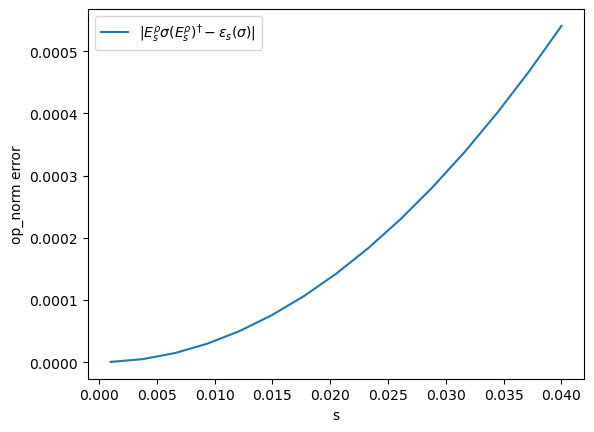

In [18]:
s_grid = np.linspace(0.001, 0.04, 15)
error1_s_list = []
for s in s_grid:
    DME_s = DME(s, rho, sigma)
    DME_goal = evolve(s,rho) @ sigma @ np.conjugate(evolve(s, rho)).T
    error1_s = np.linalg.norm(np.abs(DME_goal - DME_s))
    error1_s_list.append(error1_s)
plt.plot(s_grid, error1_s_list, label=r'$|E_s^\rho\sigma (E_s^\rho)^\dag- \varepsilon_s(\sigma)|$')
plt.xlabel('s')
plt.ylabel('op_norm error')
plt.legend()

In [19]:
trotter_step = 1
s = 0.01
DME_goal = evolve(s,rho) @ sigma @ np.conjugate(evolve(s, rho)).T
# rho: quantum instruction, sigma: quantum register
def DME_trotterize(s, rho, sigma, steps):
    result = sigma
    for M in range(steps):
        result = DME(s/steps, rho, result)
    return result
DME_trotter = DME_trotterize(s, rho, sigma, trotter_step)
print(DME_trotter)
print(DME_goal)

[[ 1.19209592e-01+0.j         -3.14081258e-05+0.00239194j]
 [-3.14081258e-05-0.00239194j  8.80790408e-01+0.j        ]]
[[ 1.19210435e-01+2.71050543e-20j -7.51335212e-06+2.39207278e-03j]
 [-7.51335212e-06-2.39207278e-03j  8.80789565e-01+0.00000000e+00j]]


Text(0, 0.5, 'Trace norm')

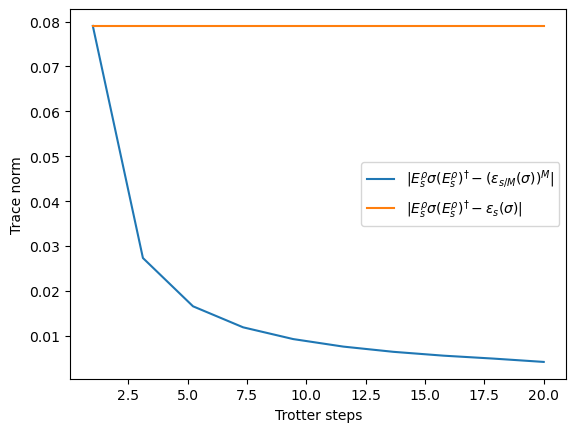

In [25]:
s = 0.5
DME_s = DME(s, rho, sigma)
DME_goal = evolve(s,rho) @ sigma @ np.conjugate(evolve(s, rho)).T
error1_s = np.linalg.norm(np.abs(DME_goal - DME_s))
trotter_steps_list = np.linspace(1,20,10)
error1_list = error1_s * np.ones(len(trotter_steps_list))
trotter_error_list = []
trotter_error_list2 = []
for M in trotter_steps_list:
    trotter_step = int(M)
    DME_trotter = DME_trotterize(s, rho, sigma, trotter_step)
    # DME_trotter2 = np.linalg.matrix_power(evolve(s/trotter_step,rho) @ sigma @ np.conjugate(evolve(s/trotter_step, rho)).T, trotter_step)
    # Use trace norm
    error = np.linalg.norm(DME_goal - DME_trotter)
    # error2 = op_norm(DME_goal - DME_trotter2)
    trotter_error_list.append(error)
    # trotter_error_list2.append(error2)

plt.plot(trotter_steps_list, trotter_error_list, label=r'$|E_s^\rho\sigma (E_s^\rho)^\dag - (\varepsilon_{s/M}(\sigma))^M|$')
# plt.plot(trotter_steps_list, trotter_error_list2, label=r'$ \varepsilon_s(\sigma)-(E_{s/M}\sigma E_{s/M}^\dag)^M$')
plt.plot(trotter_steps_list, error1_list, label=r'$|E_s^\rho\sigma (E_s^\rho)^\dag-\varepsilon_{s}(\sigma)|$')
plt.legend()
plt.xlabel('Trotter steps')
plt.ylabel('Trace norm')